In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import cv2 as cv

from tqdm import tqdm


In [2]:
dataset = "sd1_sample"

src = Path("./data/") / dataset / "extracted_imgs"
dst = Path("./data/") / dataset / "labels"
if not dst.exists():
    dst.mkdir(parents=True)


In [3]:
imgs = sorted(list(src.iterdir()))


In [9]:
def random_show(imgs: list, N: int = 4) -> None:
    idx = np.random.choice(len(imgs), size=N, replace=False)
    _, ax = plt.subplots(
        int(np.ceil(N // 4)), 4, figsize=(16, 6), tight_layout=True, sharey=True
    )
    ax = ax.flatten()
    for n in range(N):
        img = cv.imread(str(imgs[idx[n]]))
        ax[n].imshow(img)
        ax[n].set_title(imgs[idx[n]].parts[-1])
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])


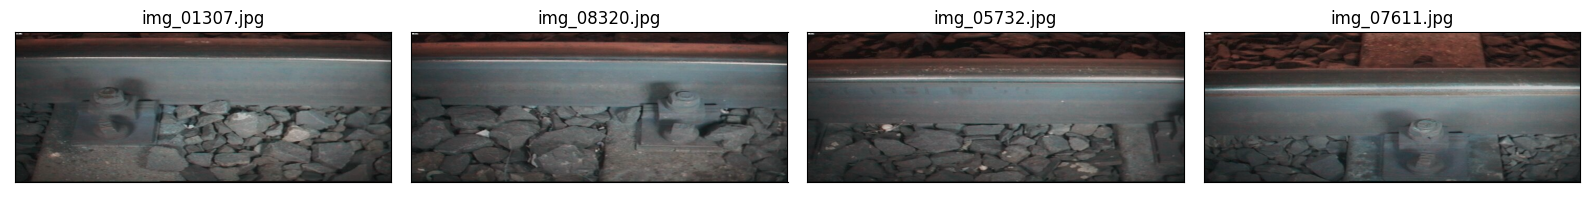

In [10]:
random_show(imgs, 4)


In [11]:
def marginal_histograms(
    img: np.ndarray, img_mod: np.ndarray, plot: bool = True
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    mean_vert = np.mean(img_mod, axis=0)
    mean_hor = np.mean(img_mod, axis=1)
    std_vert = np.std(img_mod, axis=0)
    std_hor = np.std(img_mod, axis=1)
    x1 = np.arange(len(mean_vert))
    x2 = np.arange(len(mean_hor))

    if plot:
        fig = plt.figure(figsize=(10, 6), tight_layout=True)

        gs = GridSpec(
            nrows=2, ncols=2, figure=fig, width_ratios=[3, 1], height_ratios=[1, 3]
        )

        ax0 = fig.add_subplot(gs[1, 0])
        ax1 = fig.add_subplot(gs[0, 0], sharex=ax0)
        ax2 = fig.add_subplot(gs[1, 1], sharey=ax0)

        ax0.imshow(img, aspect="auto", cmap="gray")
        ax1.plot(x1, mean_vert)
        ax1.plot(x1, std_vert)
        ax2.plot(mean_hor, x2)
        ax2.plot(std_hor, x2)

        plt.show()

    return mean_vert, mean_hor, std_vert, std_hor

Single peak detection - only grayscale converion

grad(std) alapján - grayscale + CLAHE


In [12]:
def image_manipulator(
    dataset: str, 
    img: np.ndarray, plot: bool = True
) -> tuple[np.ndarray, np.ndarray]:
    img_raw = cv.imread(str(img))
    img = cv.cvtColor(img_raw, cv.COLOR_BGR2GRAY)

    img_mod = img

    if dataset == "sd1_linear_sample":
        clahe   = cv.createCLAHE()
        img_mod = clahe.apply(img)
        
    # img_mod = cv.GaussianBlur(img_mod, (7, 7), 0)
    # img_mod = cv.adaptiveThreshold(img_mod, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    # _, img_mod = cv.threshold(img_mod, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # img_mod = cv.Sobel(img_mod, cv.CV_8U, 0, 1, ksize=11)
    # img_mod = cv.Laplacian(img_mod, cv.CV_8U)

    if plot:
        _, axs = plt.subplots(1, 2, figsize=(16, 4), tight_layout=True, sharey=True)
        axs[0].imshow(img_raw)
        axs[1].imshow(img_mod, cmap="gray")
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()

    return img, img_mod

In [13]:
def detect_rail(
    dataset: str,
    img: np.ndarray,
    mean_vert: np.ndarray, mean_hor: np.ndarray, plot: bool = True
) -> tuple[np.ndarray, np.ndarray]:

    label = np.zeros(shape=(*img.shape, 3), dtype=np.uint8)
    blended = np.zeros(shape=(*img.shape, 3), dtype=np.uint8)
    max_hor = np.argmax(mean_hor)
    
    if dataset == "sd1_sample":
        min_threshold = 39
        max_threshold = 87
    elif dataset == "sd1_linear_sample":
        min_threshold = 54
        max_threshold = 173
    else:
        raise KeyError("Dataset not known")

    label[max(0, max_hor - min_threshold) : max_hor + max_threshold, :, 1] = 255

    img_3channel = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

    blended = cv.addWeighted(img_3channel, 1, label, 0.1, 0)

    if plot:
        _, ax = plt.subplots(1, 1, figsize=(16, 8))

        ax.imshow(blended)
        ax.hlines([max_hor], 0, len(mean_vert), color="green")
        ax.hlines(
            [max_hor - min_threshold, max_hor + max_threshold],
            0,
            len(mean_vert),
            color="red",
        )
        plt.show()
        
    return label, blended

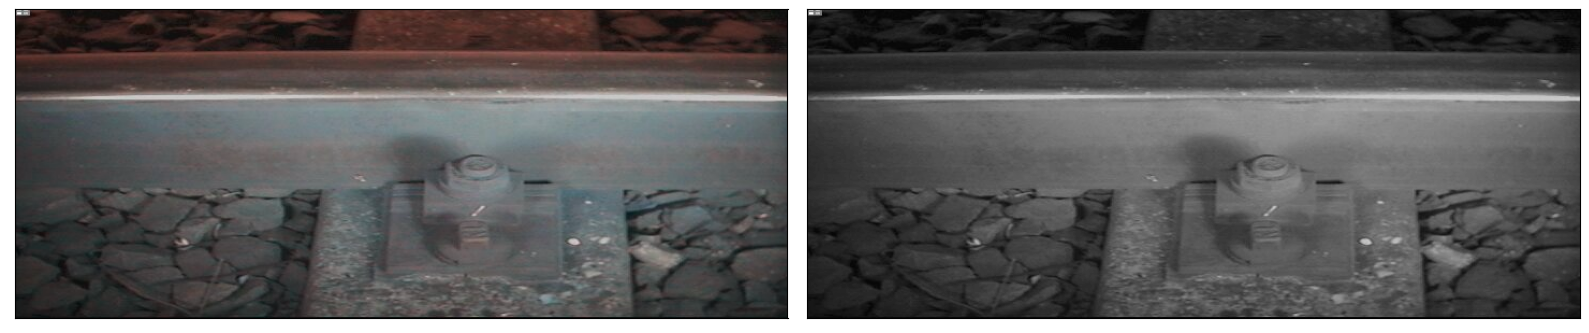

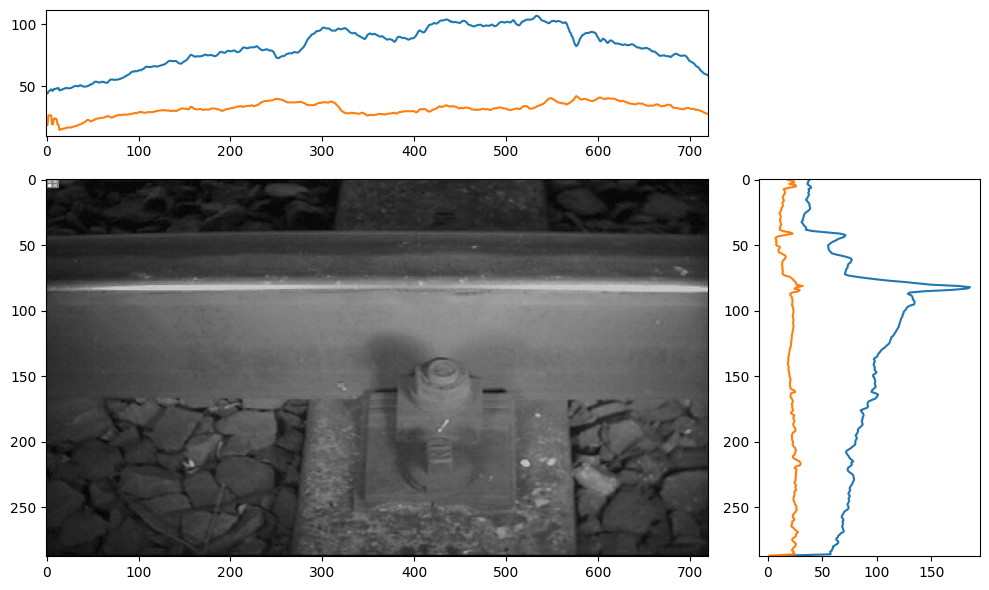

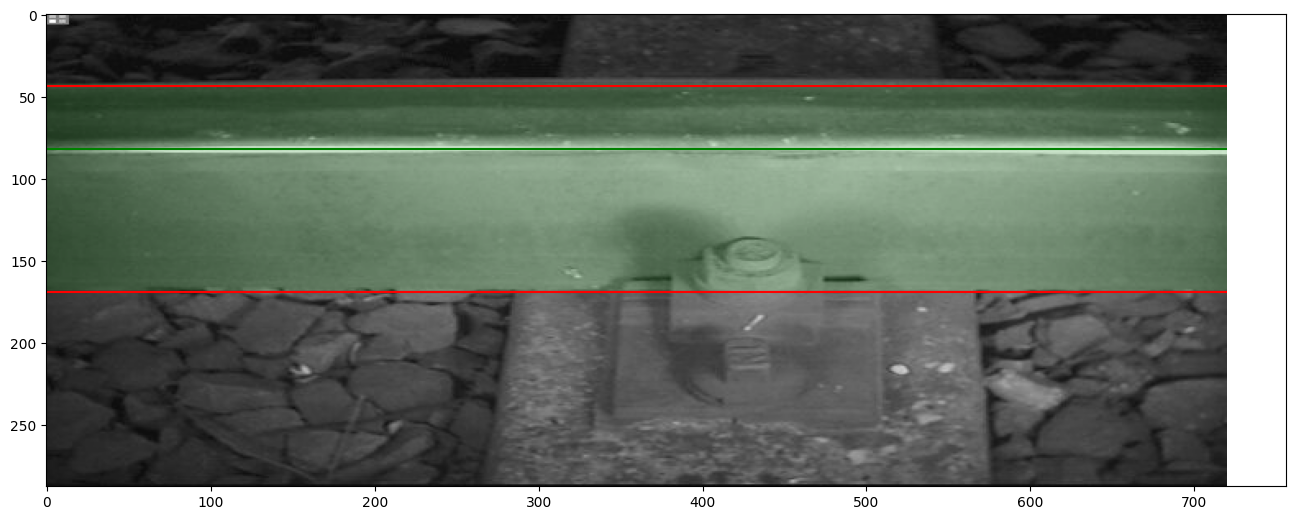

In [14]:
for _ in range(1):
    img, img_mod = image_manipulator(dataset, imgs[np.random.choice(len(imgs))], plot=True)
    res = marginal_histograms(img, img_mod, plot=True)
    label, blended = detect_rail(dataset, img_mod, *res[:2], plot=True)

In [31]:
for img in tqdm(imgs):
    image, image_mod = image_manipulator(dataset, img, plot=False)
    histograms = marginal_histograms(image, image_mod, plot=False)
    label, blended = detect_rail(dataset, image_mod, *histograms[:2], plot=False)
    label_path = Path(*img.parts[:-2]) / "labels" / img.parts[-1]
    blended_path = Path(*img.parts[:-2]) / "blended_imgs" / img.parts[-1]

    cv.imwrite(str(label_path), label)
    cv.imwrite(str(blended_path), blended)


100%|██████████| 2387/2387 [03:03<00:00, 13.00it/s]
